# SIMULATING SYSTEM ELEMENTS -- CALTECH CONTROL PACKAGE

This notebook introduces core elements of the CalTech control package and provides various examples of using the with Tellurium.

# Preliminaries

In [1]:
import control
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te
import controlSBML as ctl

## Antimony Models

### Linear Model

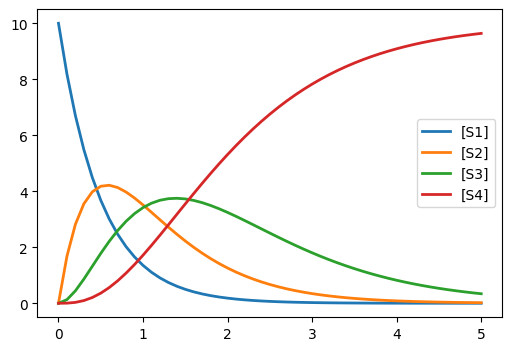

In [2]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_DATA = LINEAR_RR.simulate()
LINEAR_RR.plot(LINEAR_DATA)
LINEAR_STATE_NAMES = ["S1", "S2", "S3", "S4"]
LINEAR_PARAM_DCT = {"input_names": LINEAR_STATE_NAMES, "output_names": LINEAR_STATE_NAMES}

# Helpers

In [3]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

In [4]:
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1"], output_names=["S2"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

In [5]:
def plotModel(model=TEST_MODEL, parameter_dct=None, title="", is_plot=True):
    """
    Plots the simulation with the specified parameter values.
    
    Parameters
    ----------
    model: str
    parameter_dct: dict
        key: parameter name
        value: parameter value
    is_plot: bool
    
    Returns
    -------
    NamedArray
    """
    if parameter_dct is None:
        parameter_dct = {}
    rr = te.loada(model)
    for name, value in parameter_dct.items():
        rr[name] = value
    simulation_results = rr.simulate()
    if is_plot:
        rr.plot(simulation_results, title=title)
    return simulation_results
    
# TESTS
results = plotModel(is_plot=False)
assert("NamedArray" in str(type(results)))
print("OK")

OK


In [6]:
def plotSys(sys, times=None, initial_values=None, forced_input=None, title="", ax=None, is_plot=True):
    """
    Plots the system.
    
    Parameters
    ----------
    sys: NonlinearIOSystem
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float
    ax: matplotlib.Axes
    
    Returns
    -------
    np.ndarray, np.ndarray, ax (times, predicted values, plot axis)
    """
    if times is None:
        times = np.linspace(0, 5, 100)
    if forced_input is None:
        forced_input = 0
    if initial_values is None:
        initial_values = ctl.makeStateVector(sys)
    if ax is None:
        _, ax = plt.subplots(1)
    # Simulate the system
    t, y = control.input_output_response(sys, times, forced_input, initial_values)
    # Plot the response
    num_output = len(sys.output_labels)
    if num_output == 1:
        plt.plot(t, y)
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    ax.legend(sys.output_labels)
    if not is_plot:
        plt.close()
    return t, y, ax
    
# Tests
times = T = np.linspace(0, 70, 500)
times, predictions, _ = plotSys(TEST_SYS, times, is_plot=False)
assert(len(times) == len(predictions))
print("OK!")

OK!


# The ``control`` Package

Provides a wide range of capabilities for defining, analyzing, and designing systems.
This lecture focuses on the following:
* Defining a system using the ``NonlinearIOSystem`` class.
* Simulating a system using ``input_output_response``


## Defining a System

A system is defined by a combination of a state transition function and an output function.
* The state transition function returns the time derivative of each state variable. The ``controls`` solver computes
the integral of these derivatives to calculate the values of state variables.
* The output function returns the value of all outputs at the current state.

An example.

## Predator-Prey Example

The system consists of $H$ prey and $L$ preditors with the parameters $a, b, c, d, k, r$ and
subject to the equations. (Details are at http://www.cds.caltech.edu/~murray/amwiki/index.php/Predator_prey)

The **state variables** for this model are $H$ and $L$. The **state equations** describe how the
state variables change over time.

\begin{eqnarray}
\dot{H} & = & (r + u)H( 1 - \frac{H}{k})  - \frac{a  H L}{c + H},~ H\geq 0 \\
\dot{L} & = & b \frac{a HL}{c + H} - dL, L \geq 0 \\
\end{eqnarray}

where $\dot{H}, \dot{L}$ are derivatives w.r.t. time.

The ``control.NonlinearIOSystem`` object represents a system of non-linear differential equations.
Its specification requires two functions:
* ``updfcn`` - a function that calculates the derivatives of state variables
* ``outfcn`` - a function that calculates outputs from the state variables

In [7]:
def updfcnPP(time, x_vec, u_vec, param_dct):
    """
    Calculates the derivative of populations of hare (H) and lynx (L).
    
    Parameters
    ----------
    time: float (time of state)
    x_vec: array-float (H, L)
    u_vec: list-float (change to hare population)
    param_dct: dictionary of other parameters
    
    Returns
    -------
    list-float (dH, dL)
    """
    # Parameter setup
    a = param_dct.get('a', 3.2)  # Get value assigned to 'a' or its default
    b = param_dct.get('b', 0.6)
    c = param_dct.get('c', 50.)
    d = param_dct.get('d', 0.56)
    k = param_dct.get('k', 125)
    r = param_dct.get('r', 1.6)

    # Map the states into local variable names
    H = x_vec[0]
    L = x_vec[1]

    # Compute the control action (only allow addition of food)
    u = u_vec[0] if u_vec[0] > 0 else 0

    # Compute the discrete updates
    dH = (r + u) * H * (1 - H/k) - (a * H * L)/(c + H)
    dL = b * (a * H *  L)/(c + H) - d * L

    return [dH, dL]

# Tests
result = updfcnPP(0, [10, 2], [1], {})
assert(len(result) == 2)
print("OK!")

OK!


In [8]:
def outfcnPP(time, x_vec, u_vec, param_dct):
    """
    Calculates H and L from the state vector. This is just the value of the state vector.
    """
    return x_vec

# Tests
assert(len(outfcnPP(0, [0, 1], None, None)) == 2)
print("OK")

OK


Constructing the ``NonlinearIOSystem`` object requires ``updfcn`` and ``outfcn`` along with:
* inputs: name of the inputs to the system
* outputs: name of the outputs from the same
* names: of the state variables (in this case, the same as the outputs)
* name of the system (I strongly suggest using the name of the object)

The input, output, and system names are used latter when we connect systems together.

In [9]:
# This constructs the NonlinearIOSystem object.
predprey = control.NonlinearIOSystem(
    updfcnPP, outfcnPP, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='predprey')

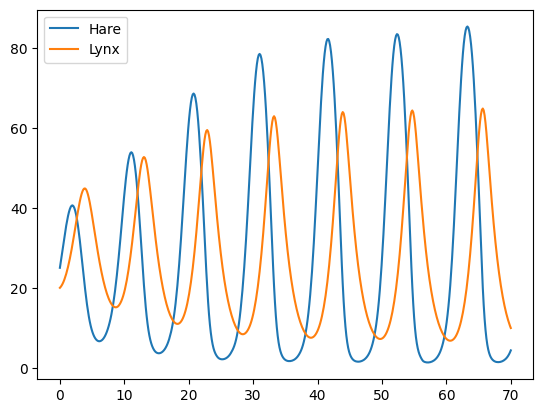

In [10]:
# Simulate the system
X0 = [25, 20]                 # Initial H, L
T = np.linspace(0, 70, 500)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(predprey, T, 0, X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.show(block=False)

In [11]:
y

array([[25.        , 26.51807873, 28.07016256, 29.6361136 , 31.19247454,
        32.71492505, 34.17828175, 35.55649822, 36.82266502, 37.94900964,
        38.90691524, 39.67189684, 40.22184052, 40.53635964, 40.60013491,
        40.40291448, 39.93951389, 39.20981608, 38.2187714 , 36.9763976 ,
        35.4982168 , 33.81206181, 31.95439837, 29.96343512, 27.87899312,
        25.74250582, 23.59701911, 21.48719124, 19.45929293, 17.56120725,
        15.82570513, 14.2542805 , 12.85577177, 11.63278333, 10.58138091,
         9.69109164,  8.94490401,  8.32172592,  7.81422036,  7.41137246,
         7.10204004,  6.87705215,  6.72920905,  6.65328221,  6.64600173,
         6.70456026,  6.82764491,  7.015865  ,  7.27090861,  7.59554263,
         7.99361274,  8.4700434 ,  9.03083789,  9.68307826, 10.4333557 ,
        11.28219573, 12.24529703, 13.33827372, 14.57327779, 15.95899907,
        17.50066524, 19.20004184, 21.05543227, 23.06167776, 25.21015742,
        27.48878819, 29.88202487, 32.38202868, 34.9

# NonlinearIOSystem for PI controller

Let $u(t)$ be the input to the PI controller (control error) and $y(t)$ be the output.

* State variables: $x(t) = \int_0^t u(s) ds$
* State equation: $\dot{x} = u(t)$
* Output equation: $y(t) = k_P u(t) + k_I x(t)$

In [12]:
ref = 1
kP = 1
kI = 0.5
def updfcnPI(_, __, u_vec, ___):
    """
    Calculates the derivative of the state variable
    
    Parameters
    ----------
    u_vec: float (control error)
    
    Returns
    -------
    list-float (dH, dL)
    """
    return ref - u_vec[0]

# Tests
assert(-1 == updfcnPI(None, None, [2], None))
print("OK!")

OK!


In [13]:
def outfcnPI(time, x_vec, u_vec, __):
    """
    Calculates H and L from the state vector. This is just the value of the state vector.
    
    Parameters
    ----------
    x_vec: array-float (integral of control error)
    u_vec: float (current control error)
    
    Returns
    -------
    float (control output)
    """
    return kP*(ref - u_vec) + kI*x_vec[0]

# Tests
assert(2 == outfcnPI(None, [4], 1, None))
print("OK!")

OK!


In [14]:
pi_controller = control.NonlinearIOSystem(
    updfcnPI, outfcnPI, inputs=('measured_output'), outputs="control_input",
    states=1, name='pi_controller')

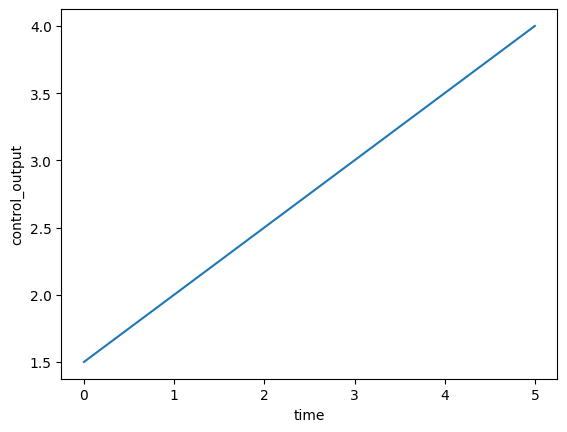

In [15]:
times = [0.1*n for n in range(51)]
t, y = control.input_output_response(pi_controller, times, 0, 1)
plt.plot(t, y)
plt.xlabel("time")
_ = plt.ylabel("control_output")

# Creating ``NonlinearIOSystem`` Objects for ``LINEAR_MDL``

The original model is:

\begin{eqnarray}
J_1: S_1 & \xrightarrow{k_1 S_1} S_2 \\
J_2: S_2 & \xrightarrow{k_2 S_2} S_3 \\
J_3: S_3 & \xrightarrow{k_3 S_3} S_4 \\
\end{eqnarray}

## System Equations

The system equations are the differential equations that relate the floating species to other
floating species.

Note that $S_1$ is affected only by $J_1$. So, $\dot{S}_1 = -k_1 S_1$.

$S_2$ increases with $J_1$ and decreases with $J_2$. So,
$\dot{S}_2 = k_1 S_1 - k_2 S_2$.

The full set of equations is:

$
\begin{eqnarray}
\dot{S}_1 & =&  -& k_1 S_1 & +&  0 S_2 &+& 0 S_3 \\
\dot{S}_2 &=& + & k_1 S_1  &-& k_2 S_2 &+& 0S_3 \\
\dot{S}_3 &=& +& 0S_1 &+& k_2 S_2 &-& k_3 S_3 \\
\dot{S}_4 &=& +& 0S_1 &+& 0 S_2 &+& k_3 S_3
\end{eqnarray}
$

## Object construction

The state update function of this model uses the system equations to calculate the time derivatives
for each state variable, $S_1, S_2, S_3, S_4$.

In [16]:
def updfcnLinear(_, x_vec, u_vec, param_dct):
    """
    Calculates the derivative of populations of hare (H) and lynx (L).
    
    Parameters
    ----------
    x_vec: array-float (S1, S2, S3, S4)
    u_vec: float
    param_dct: dictionary of other parameters (k1, k2, k3)
    
    Returns
    -------
    list-float (dS1, dS2, dS3, dS4)
    """
    # Initializations
    k1 = param_dct.get("k1", 2.0)
    k2 = param_dct.get("k2", 1.5)
    k3 = param_dct.get("k3", 1.0)
    s1 = x_vec[0]
    s2 = x_vec[1]
    s3 = x_vec[2]
    s4 = x_vec[3]
    #
    ds1 = -k1*s1 + u_vec[0]
    ds2 = k1*s1 - k2*s2
    ds3 = k2*s2 - k3*s3
    ds4 = k3*s3
    #
    return [ds1, ds2, ds3, ds4]

# Tests
result = updfcnLinear(None, [10, 0, 0, 0], [0], {})
assert(len(result) == 4)
assert(np.isclose(result[3], 0))
print("OK!")

OK!


In this case, the output function gives the values of the state variables.

In [17]:
def outfcnLinear(_, x_vec, __, ___):
    """
    Returns
    -------
    float: S1, S2, S3, S4
    """
    return x_vec

# Tests
assert(len(outfcnPP(None, [1, 1, 1, 1], None, None)) == 4)
print("OK!")

OK!


Now, we construct the ``NonlinearIOSystem`` obeject, and simulate it.

In [18]:
state_names = ["S1", "S2", "S3", "S4"]
output_names = state_names
linear_sys = control.NonlinearIOSystem(
    updfcnLinear, outfcnLinear, inputs=('u'), outputs=output_names,
    states=state_names, name='linear_sys')

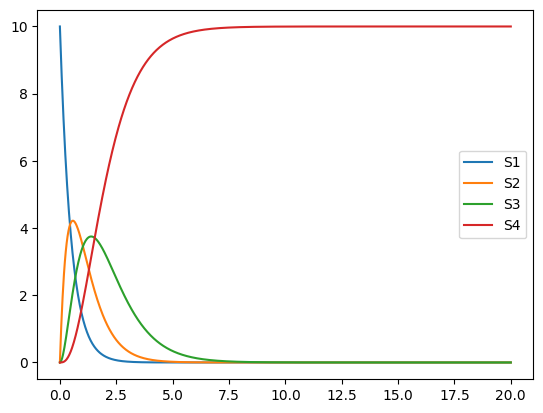

In [19]:
def simulateLinearSys(sys):
    # Simulate the system
    X0 = [10, 0, 0, 0]               # Initial conditions for species concentrations
    T = np.linspace(0, 20, 1000)   # Simulation 70 years of time

    # Simulate the system
    t, y = control.input_output_response(sys, T, 0, X0)

    # Plot the response
    plt.figure(1)
    for idx in range(len(output_names)):
        plt.plot(t, y[idx])
    plt.legend(output_names)
    plt.show(block=False)
simulateLinearSys(linear_sys)

In [20]:
output_names

['S1', 'S2', 'S3', 'S4']

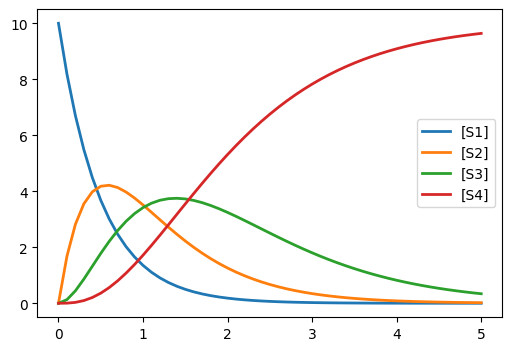

In [21]:
# Compare with the Tellurium simulation
LINEAR_RR.plot(LINEAR_DATA)

# Writing ``updfcn`` and ``outfcn`` in general for an SBML model

We want to create ``NonlinearIOSystem`` objects for SBML models.
This could be done by manually examining the models and constructing a set of equations, but doing so
is time consuming and error prone.
Below, we develop a general method.

In [22]:
# We can get the derivative of a species concentration at the current simulation time
#timepoint = 0.5  # Time at which we want the derivative
#LINEAR_RR.reset()  # Start at time 0
#_ = LINEAR_RR.simulate(0, timepoint)  # Simulate to the timepoint
# Set values of state
LINEAR_RR["S1"] = 10
LINEAR_RR["S2"] = 0
LINEAR_RR["S3"] = 0
LINEAR_RR["S4"] = 0
# Get the derivatives
ds1 = LINEAR_RR["S1'"]
ds2 = LINEAR_RR["S2'"]
ds3 = LINEAR_RR["S3'"]
ds4 = LINEAR_RR["S4'"]
[ds1, ds2, ds3, ds4]

[-20.0, 20.0, 0.0, 0.0]

In [23]:
def updfcnSBML(timepoint, x_vec, __, param_dct):
    """ 
    Calculates the derivative of populations of hare (H) and lynx (L).

    Parameters
    ----------
    x_vec: array-float (S1, S2, S3, S4)
    param_dct: dict
        "roadrunner": ExtendedRoadrunner
        "state_names": list of states

    Returns
    -------
    list-float (same size as state)
    """
    state_names = param_dct["state_names"]
    roadrunner = param_dct["roadrunner"]
    roadrunner.reset()
    if timepoint < 2:
        # Too small of change
        dstates = np.repeat(0.0, len(state_names))
    else:
        # Run a simulation
        _ = roadrunner.simulate(0, timepoint, 2)
        #   
        for idx, state_name in enumerate(state_names):
            roadrunner[state_name] = x_vec[idx]
        #   
        dstates = []
        for state_name in state_names:
            name = "%s'" % state_name
            dvalue = roadrunner[name]
            dstates.append(dvalue)
    #   
    return dstates

# Tests
param_dct = {"roadrunner": LINEAR_RR, "state_names": ["S1", "S2", "S3", "S4"]}
result = updfcnSBML(1, [10, 0, 0, 0], None, param_dct)
assert(len(result) == 4)
print("OK!")

OK!


In [24]:
def outfcnSBML(_, x_vec, __, param_dct):
    """
    Calculates the derivative of populations of hare (H) and lynx (L).
    
    Parameters
    ----------
    x_vec: array-float (S1, S2, S3, S4)
    param_dct: dict
        "state_names" list-str
        "output_names": list-str (subset of states)
    
    Returns
    -------
    list-float (same size as state)
    return x_vec
    """
    state_names = param_dct["state_names"]
    output_names = param_dct["output_names"]
    #
    output_vals = []
    for idx, state_name in enumerate(state_names):
        if state_name in output_names:
            output_vals.append(x_vec[idx])
    #
    return output_vals

# Tests
param_dct = {"roadrunner": LINEAR_RR, "state_names": ["S1", "S2", "S3", "S4"], "output_names": ["S2", "S3"]}
output_vals = outfcnSBML(None, [1, 1, 1, 1], None, param_dct)
assert(len(output_vals) == 2)
print("OK!")

OK!


In [25]:
output_names = ["S1", "S2", "S3", "S4"]
param_dct = {"roadrunner": LINEAR_RR, "state_names": ["S1", "S2", "S3", "S4"], "output_names": output_names}
linear_sbml_sys = control.NonlinearIOSystem(
    updfcnSBML, outfcnSBML, inputs=('u'), outputs=param_dct["output_names"],
    states=param_dct["state_names"], name='linear_sbml_sys')

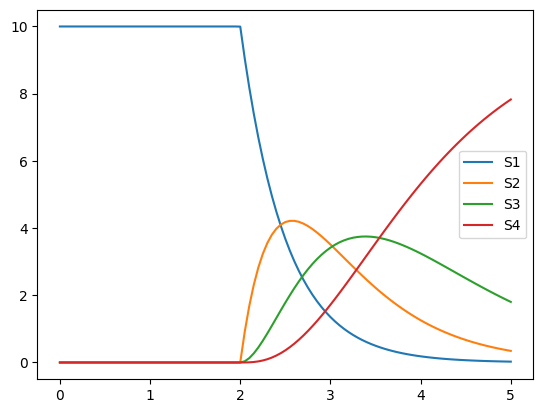

In [26]:
# Simulate the system
X0 = [10, 0, 0, 0]               # Initial conditions for species concentrations
T = np.linspace(0, 5, 101) 

# Simulate the system
t, y = control.input_output_response(linear_sbml_sys, T, 0, X0, params=param_dct)

output_names = param_dct["output_names"]
# Plot the response
plt.figure(1)
for idx in range(len(output_names)):
    plt.plot(t, y[idx])
plt.legend(output_names)
plt.show(block=False)

# Using ControlSBML to make SBML NonlinearIOSystem

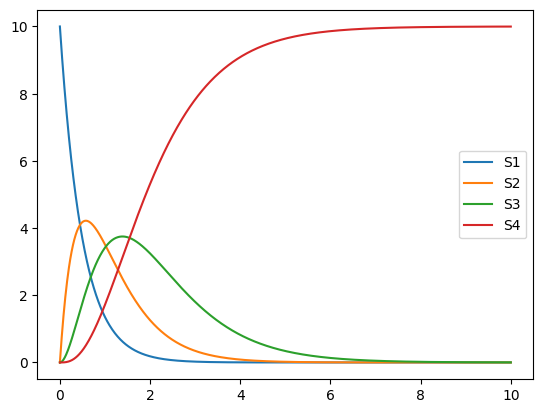

In [27]:
ctlsb = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S1", "S2","S3", "S4"])
sys = ctlsb.makeNonlinearIOSystem("linear")
times = np.linspace(0, 10, 1000)
_ = plotSys(sys, times, initial_values=[10, 0, 0, 0], forced_input=np.repeat(0, len(times)))

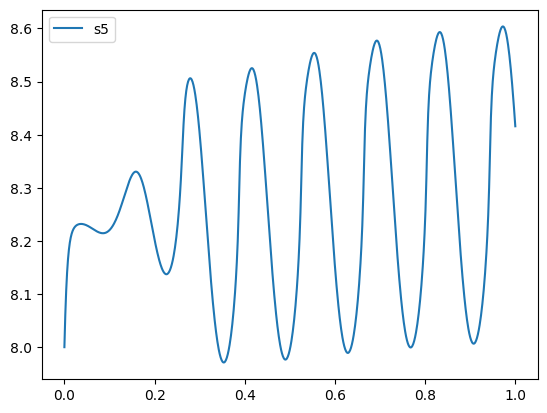

In [28]:
# Selecting a model from BioModels and simulating it.
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
sys = ctlsb.makeNonlinearIOSystem("wolf")
times = np.linspace(0, 1, 1000)
_ = plotSys(sys, times, forced_input=np.repeat(0, len(times)))